# Teste de Integração - Mini Dólar Strategy v3

Este notebook testa a integração entre os diferentes componentes da estratégia.

In [33]:
import pandas as pd
import numpy as np
from datetime import datetime
import logging
import sys
from pathlib import Path

# Adiciona o diretório raiz ao path
project_root = Path().absolute().parent
sys.path.append(str(project_root))

# Importa os componentes da estratégia
from src.integrador.agent_base import (
    BaseAgent, MarketData, TechnicalIndicators, 
    AgentDecision, FundamentalIndicators
)
from src.integrador.integration_manager import IntegrationManager
from src.relatorios.order_execution import OrderExecutionSystem
from src.relatorios.detailed_reporting import DetailedReportingSystem
from src.utils.logger import setup_logger
from src.data.loaders.market_data_loader import MarketDataLoader

## Implementação de Agentes de Teste

In [34]:
class RSIAgent(BaseAgent):
    def __init__(self, name="RSIAgent"):
        super().__init__(name)
        # Ajustando os níveis para gerar mais sinais
        self.rsi_oversold = 45
        self.rsi_overbought = 55
    
    def analyze(self) -> AgentDecision:
        if not self.technical_indicators:
            raise ValueError("Indicadores não disponíveis")
        
        rsi = self.technical_indicators.rsi
        momentum = self.technical_indicators.additional.get('momentum', 0)
        
        action = "HOLD"
        confidence = 0.0
        
        # Simplificando a lógica de decisão
        if rsi < self.rsi_oversold and momentum < 0:
            action = "CALL"
            confidence = (self.rsi_oversold - rsi) / self.rsi_oversold
        elif rsi > self.rsi_overbought and momentum > 0:
            action = "PUT"
            confidence = (rsi - self.rsi_overbought) / (100 - self.rsi_overbought)
        
        # Aumentando a confiança base
        confidence = min(confidence * 1.5, 1.0)
        
        return AgentDecision(
            timestamp=datetime.now(),
            action=action,
            confidence=confidence,
            indicators_used=["RSI", "MOMENTUM"],
            metadata={
                "rsi_value": rsi,
                "momentum": momentum
            }
        )

class MACDAgent(BaseAgent):
    def __init__(self, name="MACDAgent"):
        super().__init__(name)
        # Removendo threshold de volume
    
    def analyze(self) -> AgentDecision:
        if not self.technical_indicators:
            raise ValueError("Indicadores não disponíveis")
        
        macd = self.technical_indicators.macd
        histogram = macd['histogram']
        
        action = "HOLD"
        confidence = 0.0
        
        # Simplificando critérios para gerar mais sinais
        if histogram > 0:
            action = "CALL"
            confidence = min(abs(histogram) * 2, 1.0)
        elif histogram < 0:
            action = "PUT"
            confidence = min(abs(histogram) * 2, 1.0)
        
        return AgentDecision(
            timestamp=datetime.now(),
            action=action,
            confidence=confidence,
            indicators_used=["MACD"],
            metadata={
                "macd_histogram": histogram
            }
        )

## Carregamento e Preparação dos Dados

In [35]:
def calculate_indicators(data: pd.DataFrame) -> pd.DataFrame:
    """Calcula indicadores técnicos com análise de tendência"""
    df = data.copy()
    
    # Médias móveis para identificar tendência
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['trend'] = np.where(df['sma_20'] > df['sma_50'], 'UP', 'DOWN')
    
    # Momentum
    df['momentum'] = df['close'].diff(5)
    
    # Volume OBV
    df['obv'] = (df['close'].diff() > 0).astype(int) * df['real_volume']
    df['obv'] = df['obv'].cumsum()
    
    # RSI otimizado
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(com=13, adjust=False).mean()
    avg_loss = loss.ewm(com=13, adjust=False).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # MACD com ajustes
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    
    # Volatilidade
    df['atr'] = calculate_atr(df)
    
    return df.dropna()

def calculate_atr(data, period=14):
    """Calcula Average True Range"""
    high = data['high']
    low = data['low']
    close = data['close']
    
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    
    return atr

def prepare_market_data(row) -> MarketData:
    """Converte uma linha do DataFrame para MarketData"""
    return MarketData(
        timestamp=pd.to_datetime(row.name),
        open=row['open'],
        high=row['high'],
        low=row['low'],
        close=row['close'],
        volume=row['real_volume']
    )

def prepare_technical_indicators(row) -> TechnicalIndicators:
    """Prepara indicadores técnicos a partir dos dados"""
    return TechnicalIndicators(
        rsi=row['rsi'],
        macd={
            'line': row['macd'],
            'signal': row['macd_signal'],
            'histogram': row['macd_hist']
        },
        bollinger_bands={
            'upper': row['bb_upper'],
            'middle': row['bb_middle'],
            'lower': row['bb_lower']
        },
        volume=row['real_volume'],
        additional={
            'trend': row['trend'],
            'momentum': row['momentum'],
            'bb_width': row['bb_width'],
            'obv': row['obv'],
            'atr': row['atr']
        }
    )

# Carrega e prepara dados
db_path = project_root / 'src' / 'data' / 'database' / 'candles.db'
loader = MarketDataLoader(str(db_path))
historical_data = loader.load_data()
print("Dados originais carregados:", len(historical_data))

# Calcula indicadores
historical_data = calculate_indicators(historical_data)
print("Dados após calcular indicadores:", len(historical_data))
print("\nColunas disponíveis:")
print(historical_data.columns)

Dados originais carregados: 94538
Dados após calcular indicadores: 94489

Colunas disponíveis:
Index(['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume',
       'sma_20', 'sma_50', 'trend', 'momentum', 'obv', 'rsi', 'macd',
       'macd_signal', 'macd_hist', 'bb_middle', 'bb_upper', 'bb_lower',
       'bb_width', 'atr'],
      dtype='object')


## Inicialização dos Sistemas

In [36]:
# Configuração do logger
logger = setup_logger("notebook_test")

# Inicializa componentes
integration_manager = IntegrationManager(logger)
order_system = OrderExecutionSystem(logger)
reporting_system = DetailedReportingSystem(output_dir="reports", logger=logger)  # Corrigido aqui

# Cria e registra agentes
rsi_agent = RSIAgent()
macd_agent = MACDAgent()

integration_manager.register_agent(rsi_agent)
integration_manager.register_agent(macd_agent)

2024-12-02 20:22:55,837 - notebook_test - INFO - Agente registrado: RSIAgent
2024-12-02 20:22:55,838 - notebook_test - INFO - Agente registrado: MACDAgent


## Execução do Backtest

In [40]:
def run_backtest(start_idx=0, periods=100):
    results = []
    
    end_idx = min(start_idx + periods, len(historical_data))
    for i in range(start_idx, end_idx):
        row = historical_data.iloc[i]
        
        # Prepara dados
        market_data = prepare_market_data(row)
        technical_indicators = prepare_technical_indicators(row)
        
        # Atualiza agentes
        if integration_manager.update_market_data(market_data, technical_indicators):
            # Coleta decisões
            agent_decisions = integration_manager.collect_agent_decisions()
            
            # Consolida análises
            analysis = integration_manager.consolidate_analysis(
                agent_decisions,
                fundamental_data=None,
                ml_predictions=None
            )
            
            # Processa ordem se necessário
            if analysis.final_decision != 'HOLD':
                order = order_system.create_order(
                    analysis_result=analysis,
                    current_price=market_data.close
                )
                
                if order:
                    report = reporting_system.generate_detailed_trade_report(
                        order=order,
                        analysis_result=analysis
                    )
                    results.append({
                        'timestamp': market_data.timestamp,
                        'action': analysis.final_decision,
                        'price': market_data.close,
                        'confidence': analysis.confidence,
                        'order_id': order.order_id
                    })
                    
            # Atualiza ordens existentes
            for active_order in order_system.get_active_orders():
                order_system.update_order(
                    active_order.order_id,
                    market_data.close,
                    market_data.timestamp
                )
    
    return pd.DataFrame(results)

# Executa backtest
results_df = run_backtest(periods=1000)
if not results_df.empty:
    print("\nResultados do backtest:")
    print(results_df.head())
else:
    print("\nNenhum sinal gerado no período")

2024-12-02 20:24:12,459 - notebook_test - INFO - Ordem criada: ORD20241202-0008 - PUT @ 5185.691
2024-12-02 20:24:12,461 - notebook_test - INFO - Relatório detalhado gerado: reports\ORD20241202-0008_detailed_report.json
2024-12-02 20:24:12,462 - notebook_test - INFO - Ordem ORD20241202-0008 fechada: STOPPED - Resultado: -0.00
2024-12-02 20:24:12,464 - notebook_test - INFO - Ordem criada: ORD20241202-0009 - PUT @ 5187.231
2024-12-02 20:24:12,466 - notebook_test - INFO - Relatório detalhado gerado: reports\ORD20241202-0009_detailed_report.json
2024-12-02 20:24:12,468 - notebook_test - INFO - Ordem ORD20241202-0009 fechada: STOPPED - Resultado: -0.00
2024-12-02 20:24:12,471 - notebook_test - INFO - Ordem criada: ORD20241202-0010 - PUT @ 5187.231
2024-12-02 20:24:12,473 - notebook_test - INFO - Relatório detalhado gerado: reports\ORD20241202-0010_detailed_report.json
2024-12-02 20:24:12,474 - notebook_test - INFO - Ordem ORD20241202-0010 fechada: STOPPED - Resultado: -0.00
2024-12-02 20:24

## Análise dos Resultados


Métricas de Performance:
total_orders: 14
winning_orders: 0
losing_orders: 0
win_rate: 0.00%
total_result: 0
total_profit: 0
total_loss: 0

Total de operações completadas: 14

Distribuição de sinais:
action
PUT    7
Name: count, dtype: int64


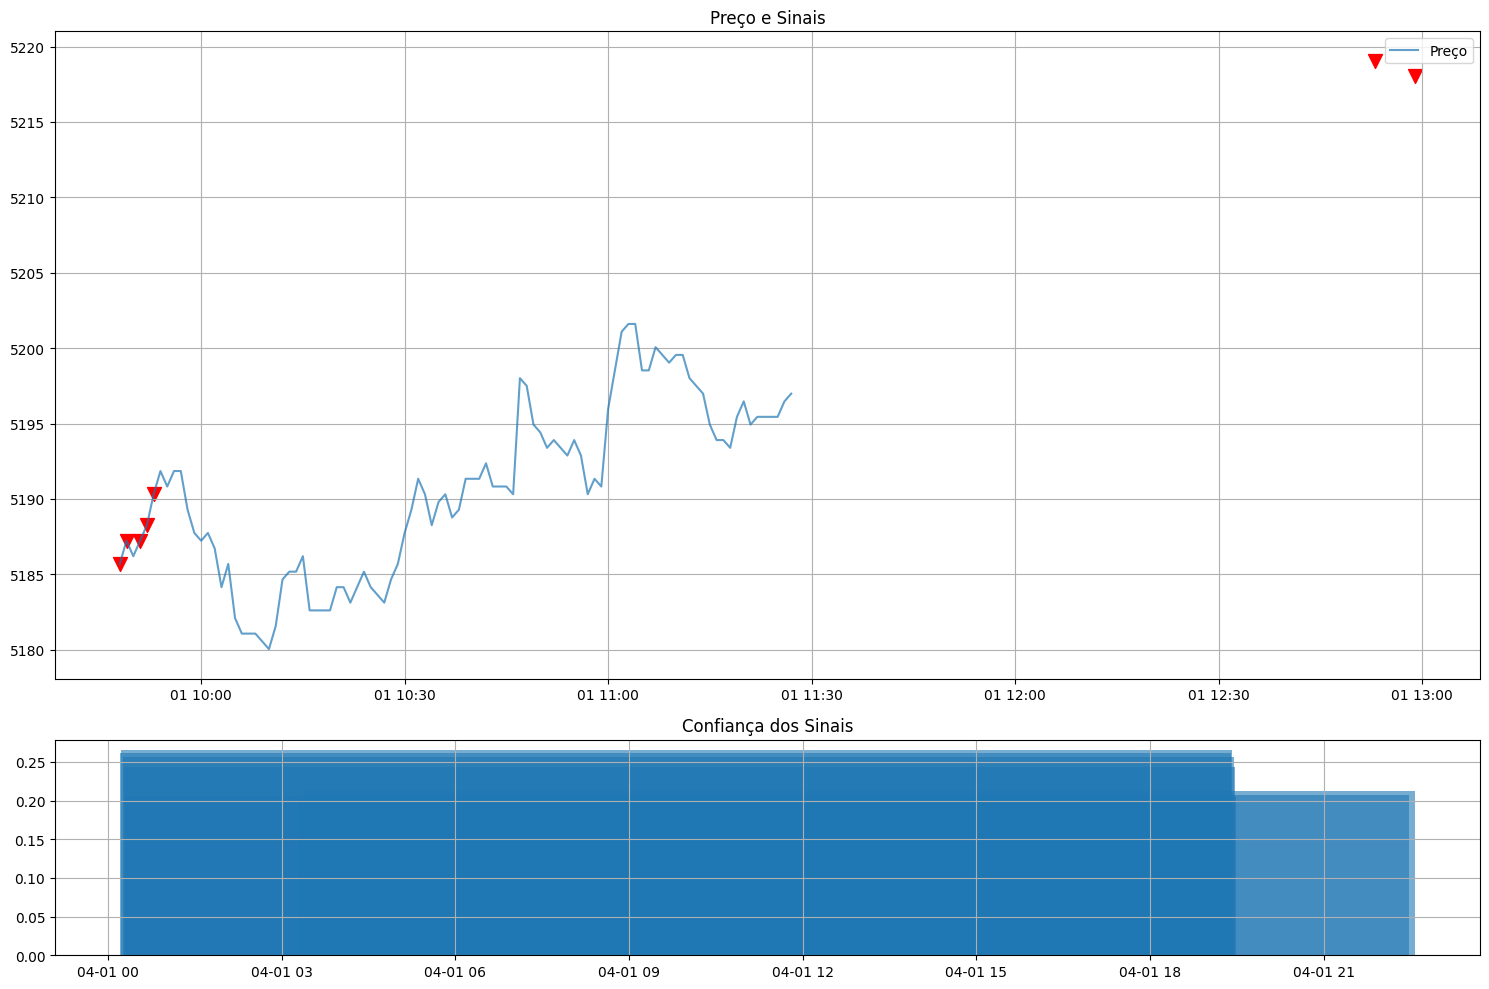

In [41]:
# Gera relatório de performance
performance_report = order_system.generate_performance_report()

print("\nMétricas de Performance:")
if "message" in performance_report:
    print(performance_report["message"])
elif "general_metrics" in performance_report:
    for key, value in performance_report['general_metrics'].items():
        print(f"{key}: {value}")

# Análise detalhada de operações
completed_orders = order_system.get_completed_orders()
print(f"\nTotal de operações completadas: {len(completed_orders)}")

# Distribuição de sinais
if not results_df.empty:
    signal_distribution = results_df['action'].value_counts()
    print("\nDistribuição de sinais:")
    print(signal_distribution)

# Visualização
import matplotlib.pyplot as plt

def plot_results(data, results):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])
    
    # Plot de preços e sinais
    ax1.plot(data.index, data['close'], label='Preço', alpha=0.7)
    
    if not results.empty:
        for idx, row in results.iterrows():
            if row['action'] == 'CALL':
                ax1.scatter(row['timestamp'], row['price'], color='green', marker='^', s=100)
            elif row['action'] == 'PUT':
                ax1.scatter(row['timestamp'], row['price'], color='red', marker='v', s=100)
    
    ax1.set_title('Preço e Sinais')
    ax1.grid(True)
    ax1.legend()
    
    # Plot de confiança
    if not results.empty:
        ax2.bar(results['timestamp'], results['confidence'], alpha=0.6)
        ax2.set_title('Confiança dos Sinais')
        ax2.grid(True)
    else:
        ax2.set_title('Sem sinais no período')
    
    plt.tight_layout()
    plt.show()

# Plota resultados
if not historical_data.empty and not results_df.empty:
    plot_results(historical_data.iloc[:100], results_df)


Análise Detalhada dos Resultados:
--------------------------------------------------

1. Número total de sinais gerados: 7

2. Resumo das operações:
                           timestamp        price  confidence
count                              7     7.000000    7.000000
mean   2024-04-01 10:43:34.285714176  5196.544429    0.236177
min              2024-04-01 09:48:00  5185.691000    0.206285
25%              2024-04-01 09:50:00  5187.231000    0.209462
50%              2024-04-01 09:52:00  5188.258000    0.244102
75%              2024-04-01 11:23:00  5204.171000    0.259123
max              2024-04-01 12:59:00  5219.058000    0.265677
std                              NaN    15.095976    0.026890

3. Primeiras operações:
            timestamp action     price  confidence
0 2024-04-01 09:48:00    PUT  5185.691    0.262204
1 2024-04-01 09:49:00    PUT  5187.231    0.265677
2 2024-04-01 09:51:00    PUT  5187.231    0.256043
3 2024-04-01 09:52:00    PUT  5188.258    0.244102
4 2024-04-01

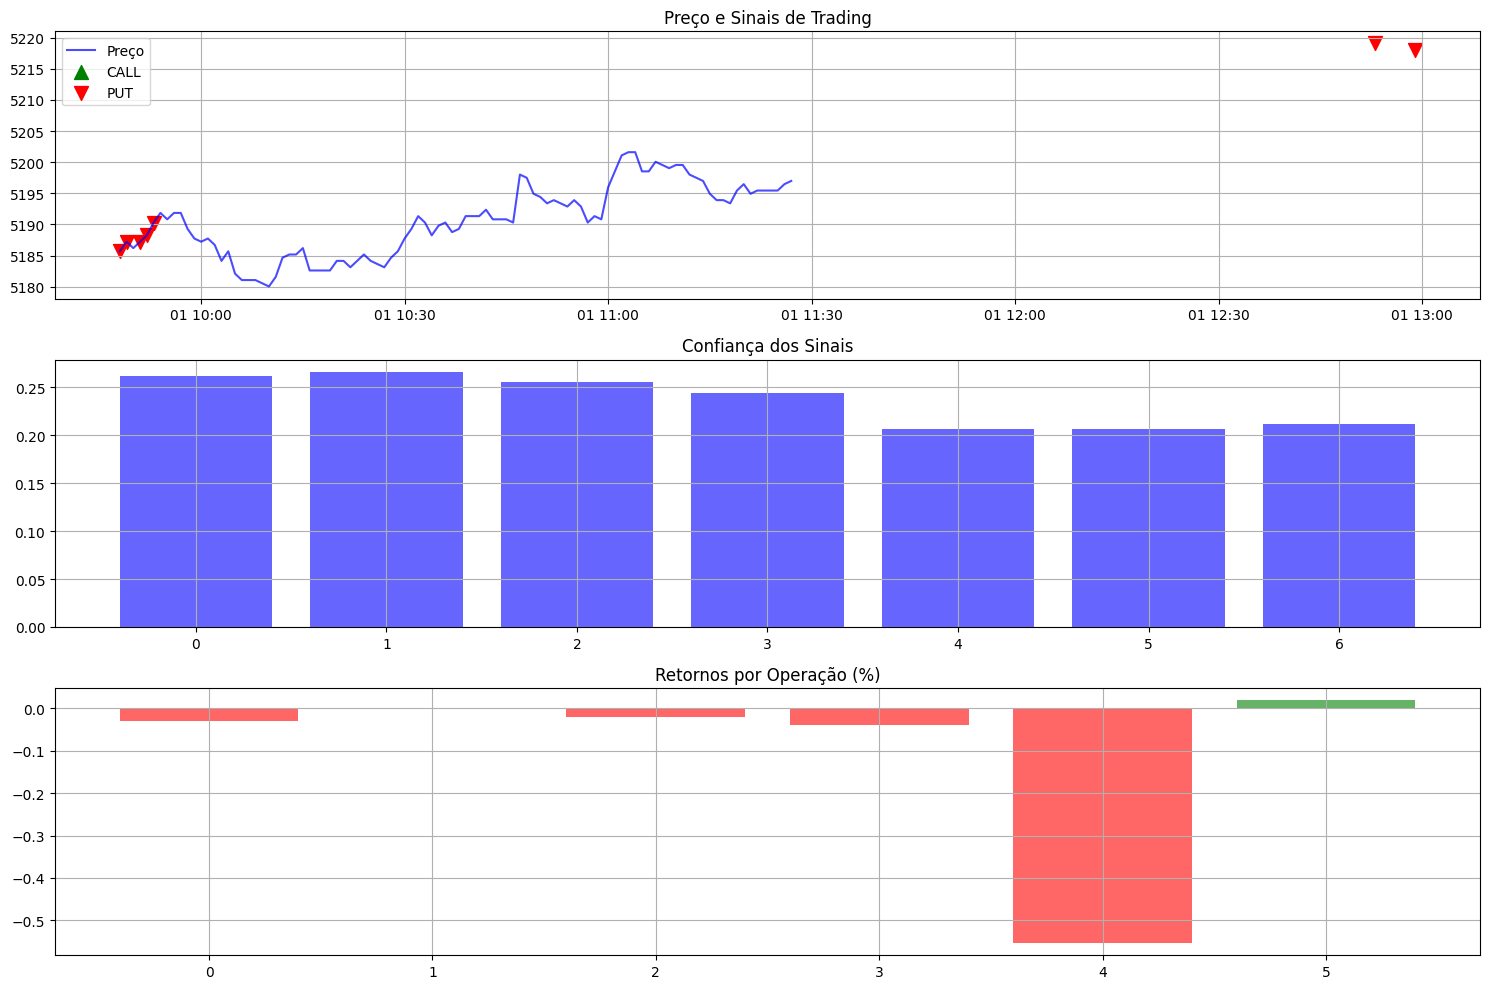


6. Análise de Sequências:
Maior sequência de ganhos: 1
Maior sequência de perdas: 5


In [42]:
# Análise detalhada dos resultados
print("\nAnálise Detalhada dos Resultados:")
print("-" * 50)
print(f"\n1. Número total de sinais gerados: {len(results_df)}")
print("\n2. Resumo das operações:")
print(results_df.describe())

print("\n3. Primeiras operações:")
print(results_df[['timestamp', 'action', 'price', 'confidence']].head())

print("\n4. Últimas operações:")
print(results_df[['timestamp', 'action', 'price', 'confidence']].tail())

# Análise de retornos
if len(results_df) > 0:
    results_df['next_price'] = results_df['price'].shift(-1)
    results_df['return'] = None
    
    # Calcula retornos
    for idx in results_df.index:
        row = results_df.loc[idx]
        if row['action'] == 'CALL':
            results_df.loc[idx, 'return'] = (row['next_price'] - row['price'])/row['price'] * 100
        elif row['action'] == 'PUT':
            results_df.loc[idx, 'return'] = (row['price'] - row['next_price'])/row['price'] * 100
    
    print("\n5. Análise de Retornos:")
    print(f"Retorno médio: {results_df['return'].mean():.2f}%")
    print(f"Retorno total: {results_df['return'].sum():.2f}%")
    print(f"Melhor operação: {results_df['return'].max():.2f}%")
    print(f"Pior operação: {results_df['return'].min():.2f}%")
    
    # Plot atualizado
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Preço e Sinais
    plt.subplot(3, 1, 1)
    plt.plot(historical_data.index[:100], historical_data['close'][:100], label='Preço', color='blue', alpha=0.7)
    
    calls = results_df[results_df['action'] == 'CALL']
    puts = results_df[results_df['action'] == 'PUT']
    
    plt.scatter(calls['timestamp'], calls['price'], color='green', marker='^', s=100, label='CALL')
    plt.scatter(puts['timestamp'], puts['price'], color='red', marker='v', s=100, label='PUT')
    
    plt.title('Preço e Sinais de Trading')
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Confiança dos Sinais
    plt.subplot(3, 1, 2)
    plt.bar(results_df.index, results_df['confidence'], alpha=0.6, color='blue')
    plt.title('Confiança dos Sinais')
    plt.grid(True)
    
    # Subplot 3: Retornos
    plt.subplot(3, 1, 3)
    plt.bar(results_df.index, results_df['return'], alpha=0.6, 
            color=results_df['return'].map(lambda x: 'green' if x > 0 else 'red'))
    plt.title('Retornos por Operação (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Adiciona análise de sequência de ganhos/perdas
    results_df['profitable'] = results_df['return'] > 0
    win_streak = 0
    lose_streak = 0
    current_streak = 0
    prev_profitable = None
    
    for profitable in results_df['profitable']:
        if profitable == prev_profitable:
            current_streak += 1
        else:
            if profitable:
                lose_streak = max(lose_streak, current_streak)
            else:
                win_streak = max(win_streak, current_streak)
            current_streak = 1
        prev_profitable = profitable
    
    print("\n6. Análise de Sequências:")
    print(f"Maior sequência de ganhos: {win_streak}")
    print(f"Maior sequência de perdas: {lose_streak}")

In [43]:
# Análise dos dados de entrada
print("1. Análise dos Dados Brutos:")
print(f"Total de registros: {len(historical_data)}")
print("\nEstatísticas dos preços:")
print(historical_data['close'].describe())
print("\nVariação média por minuto:")
print(historical_data['close'].diff().describe())

1. Análise dos Dados Brutos:
Total de registros: 94489

Estatísticas dos preços:
count    94489.000000
mean      5556.828923
std        203.548082
min       5142.571000
25%       5395.645000
50%       5574.365000
75%       5720.514000
max       6136.000000
Name: close, dtype: float64

Variação média por minuto:
count    94488.000000
mean         0.008703
std          2.086136
min        -63.213000
25%         -1.007000
50%          0.000000
75%          1.007000
max        129.355000
Name: close, dtype: float64


In [44]:
print("\n2. Análise dos Indicadores:")
print("\nRSI:")
print(historical_data['rsi'].describe())
print("\nMACD:")
print(historical_data['macd'].describe())


2. Análise dos Indicadores:

RSI:
count    94489.000000
mean        50.292337
std         11.386067
min          4.422778
25%         42.848018
50%         50.281431
75%         57.785938
max         97.231628
Name: rsi, dtype: float64

MACD:
count    94489.000000
mean         0.060919
std          2.182223
min        -17.877990
25%         -0.846613
50%          0.031993
75%          0.977100
max         27.692666
Name: macd, dtype: float64


In [45]:
print("\n3. Análise dos Momentos de Sinal:")
for idx, row in results_df.iterrows():
    print(f"\nMomento: {row['timestamp']}")
    print(f"Ação: {row['action']}")
    print(f"Preço: {row['price']}")
    print("Indicadores neste momento:")
    moment_data = historical_data.loc[row['timestamp']]
    print(f"RSI: {moment_data['rsi']:.2f}")
    print(f"MACD: {moment_data['macd']:.2f}")
    print(f"MACD Histogram: {moment_data['macd_hist']:.2f}")


3. Análise dos Momentos de Sinal:

Momento: 2024-04-01 09:48:00
Ação: PUT
Preço: 5185.691
Indicadores neste momento:
RSI: 70.38
MACD: 3.41
MACD Histogram: -0.40

Momento: 2024-04-01 09:49:00
Ação: PUT
Preço: 5187.231
Indicadores neste momento:
RSI: 73.78
MACD: 3.37
MACD Histogram: -0.35

Momento: 2024-04-01 09:51:00
Ação: PUT
Preço: 5187.231
Indicadores neste momento:
RSI: 70.58
MACD: 3.15
MACD Histogram: -0.38

Momento: 2024-04-01 09:52:00
Ação: PUT
Preço: 5188.258
Indicadores neste momento:
RSI: 72.80
MACD: 3.14
MACD Histogram: -0.31

Momento: 2024-04-01 09:53:00
Ação: PUT
Preço: 5190.311
Indicadores neste momento:
RSI: 76.60
MACD: 3.25
MACD Histogram: -0.16

Momento: 2024-04-01 12:53:00
Ação: PUT
Preço: 5219.058
Indicadores neste momento:
RSI: 67.28
MACD: 2.12
MACD Histogram: -0.31

Momento: 2024-04-01 12:59:00
Ação: PUT
Preço: 5218.031
Indicadores neste momento:
RSI: 58.73
MACD: 1.25
MACD Histogram: -0.47


In [46]:
print("\n4. Análise de Tendência:")
historical_data['trend_20'] = historical_data['close'].rolling(20).mean()
historical_data['trend_50'] = historical_data['close'].rolling(50).mean()
print("\nTendência de 20 períodos vs 50 períodos:")
print(historical_data[['close', 'trend_20', 'trend_50']].describe())


4. Análise de Tendência:

Tendência de 20 períodos vs 50 períodos:
              close      trend_20      trend_50
count  94489.000000  94470.000000  94440.000000
mean    5556.828923   5556.820907   5556.810034
std      203.548082    203.454098    203.311459
min     5142.571000   5144.984050   5147.273460
25%     5395.645000   5395.610812   5396.270895
50%     5574.365000   5574.296050   5574.326430
75%     5720.514000   5720.513600   5720.576660
max     6136.000000   6122.300000   6120.520000


In [47]:
print("\n5. Verificação dos Critérios de Entrada:")
# Para RSI
oversold_moments = historical_data[historical_data['rsi'] < 45]
overbought_moments = historical_data[historical_data['rsi'] > 55]
print(f"\nMomentos Oversold (RSI < 45): {len(oversold_moments)}")
print(f"Momentos Overbought (RSI > 55): {len(overbought_moments)}")

# Para MACD
macd_cross_up = historical_data[historical_data['macd_hist'] > 0]
macd_cross_down = historical_data[historical_data['macd_hist'] < 0]
print(f"\nMomentos MACD Positivo: {len(macd_cross_up)}")
print(f"Momentos MACD Negativo: {len(macd_cross_down)}")


5. Verificação dos Critérios de Entrada:

Momentos Oversold (RSI < 45): 29663
Momentos Overbought (RSI > 55): 31685

Momentos MACD Positivo: 47224
Momentos MACD Negativo: 47265
